In [17]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [18]:
# Upload Car Insurance Claim csv
df = pd.read_csv('../data/Car_Insurance_Claim.csv')

In [19]:
# View the first 20 rows in the dataset.
# Shows some of the possible values, but not all of them.
df.head(20)

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0
5,877557,40-64,female,majority,20-29y,high school,upper class,0.619127,1.0,after 2015,0.0,1.0,10238,13000.0,sedan,3,0,3,0.0
6,930134,65+,male,majority,30y+,high school,upper class,0.492944,0.0,after 2015,1.0,1.0,10238,13000.0,sedan,7,0,3,0.0
7,461006,26-39,female,majority,0-9y,university,working class,0.468689,0.0,after 2015,0.0,1.0,10238,14000.0,sedan,0,0,0,1.0
8,68366,40-64,female,majority,20-29y,university,working class,0.521815,0.0,before 2015,1.0,0.0,10238,13000.0,sedan,0,0,0,0.0
9,445911,40-64,female,majority,0-9y,high school,upper class,0.561531,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,1.0


In [20]:
# Check which type each variable is, which is necessary for preprocessing
# and machine learning later on
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  object 
 2   GENDER               10000 non-null  object 
 3   RACE                 10000 non-null  object 
 4   DRIVING_EXPERIENCE   10000 non-null  object 
 5   EDUCATION            10000 non-null  object 
 6   INCOME               10000 non-null  object 
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  object 
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  object 
 15  SPEEDING_VIOLATIONS  10000 non-null  

In [21]:
# Checking for unique values in data (variables defined as objects above)
print(f"""{df['AGE'].unique()}
{df['GENDER'].unique()}
{df['RACE'].unique()}
{df['DRIVING_EXPERIENCE'].unique()}
{df['EDUCATION'].unique()}
{df['INCOME'].unique()}
{df['VEHICLE_YEAR'].unique()}
{df['VEHICLE_TYPE'].unique()}""")

['65+' '16-25' '26-39' '40-64']
['female' 'male']
['majority' 'minority']
['0-9y' '10-19y' '20-29y' '30y+']
['high school' 'none' 'university']
['upper class' 'poverty' 'working class' 'middle class']
['after 2015' 'before 2015']
['sedan' 'sports car']


In [22]:
# Clean up data by removing unnecessary columns, such as ID and postal code.
# Dropping rows that contain null values. If they are left alone, it may skew
# results due to incomplete data.
df.drop(['ID'], axis=1, inplace=True)
df.drop(['POSTAL_CODE'], axis=1, inplace=True)
df = df.dropna()
df.to_csv('../data/cleaned_data.csv', index=False)
df.isnull().sum()

AGE                    0
GENDER                 0
RACE                   0
DRIVING_EXPERIENCE     0
EDUCATION              0
INCOME                 0
CREDIT_SCORE           0
VEHICLE_OWNERSHIP      0
VEHICLE_YEAR           0
MARRIED                0
CHILDREN               0
ANNUAL_MILEAGE         0
VEHICLE_TYPE           0
SPEEDING_VIOLATIONS    0
DUIS                   0
PAST_ACCIDENTS         0
OUTCOME                0
dtype: int64

In [23]:
# There are a total of 8149 entries left after removing rows that contain
# null values.
df.count()

AGE                    8149
GENDER                 8149
RACE                   8149
DRIVING_EXPERIENCE     8149
EDUCATION              8149
INCOME                 8149
CREDIT_SCORE           8149
VEHICLE_OWNERSHIP      8149
VEHICLE_YEAR           8149
MARRIED                8149
CHILDREN               8149
ANNUAL_MILEAGE         8149
VEHICLE_TYPE           8149
SPEEDING_VIOLATIONS    8149
DUIS                   8149
PAST_ACCIDENTS         8149
OUTCOME                8149
dtype: int64

In [24]:
# Preprocessing data for logistic regression model.
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), ['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS']),
        ('categorical', OneHotEncoder(handle_unknown='ignore'), ['GENDER', 'RACE', 'EDUCATION', 'INCOME', 'VEHICLE_TYPE', 'AGE', 'DRIVING_EXPERIENCE', 'VEHICLE_YEAR'])],
    remainder='passthrough')

In [25]:
# Create training and testing sets.
x = df.drop('OUTCOME', axis=1)
y = df['OUTCOME']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=64)

In [26]:
# Prepare for logistic regression.
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
    ])

In [27]:
# Train data and print accuracy.
# The accuracy ends up being around 85%, which is great.
pipeline.fit(x_train, y_train)
y_prediction = pipeline.predict(x_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_prediction))
print(classification_report(y_test, y_prediction))

Logistic Regression Accuracy: 0.849079754601227
              precision    recall  f1-score   support

         0.0       0.88      0.91      0.89      1122
         1.0       0.78      0.72      0.75       508

    accuracy                           0.85      1630
   macro avg       0.83      0.81      0.82      1630
weighted avg       0.85      0.85      0.85      1630



In [28]:
# Retrieve the names of the variables, which had previously been changed in
# in the preprocessor. The results show the importance of each variable in
# correlation with the outcome (car insurance claims).

feature_names = []
for name, transformer, columns in preprocessor.transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        feature_names.extend(transformer.get_feature_names_out(columns))
    else:
        feature_names.extend(columns)

coefficients = pd.Series(pipeline.named_steps['classifier'].coef_[0], index=feature_names)
coefficients

CREDIT_SCORE                 0.051931
VEHICLE_OWNERSHIP           -0.800927
MARRIED                     -0.163389
CHILDREN                    -0.071250
ANNUAL_MILEAGE               0.160397
SPEEDING_VIOLATIONS          0.191788
DUIS                         0.001302
PAST_ACCIDENTS              -0.357608
GENDER_female               -0.755611
GENDER_male                  0.191507
RACE_majority               -0.227552
RACE_minority               -0.336552
EDUCATION_high school       -0.149552
EDUCATION_none              -0.221326
EDUCATION_university        -0.193226
INCOME_middle class         -0.206084
INCOME_poverty              -0.113263
INCOME_upper class          -0.187663
INCOME_working class        -0.057095
VEHICLE_TYPE_sedan          -0.254413
VEHICLE_TYPE_sports car     -0.309691
AGE_16-25                   -0.009196
AGE_26-39                   -0.151101
AGE_40-64                   -0.212363
AGE_65+                     -0.191445
DRIVING_EXPERIENCE_0-9y      2.016991
DRIVING_EXPE

In [29]:
# Convert to DataFrame for easier plotting and sort by coefficient value.
coefficient_df = pd.DataFrame({
    'Feature': coefficients.index,
    'Coefficient': coefficients.values
    }).sort_values(by='Coefficient', ascending=False)
coefficient_df

,Feature,Coefficient
25,DRIVING_EXPERIENCE_0-9y,2.016991
30,VEHICLE_YEAR_before 2015,0.520076
26,DRIVING_EXPERIENCE_10-19y,0.245961
5,SPEEDING_VIOLATIONS,0.191788
9,GENDER_male,0.191507
4,ANNUAL_MILEAGE,0.160397
0,CREDIT_SCORE,0.051931
6,DUIS,0.001302
21,AGE_16-25,-0.009196
18,INCOME_working class,-0.057095


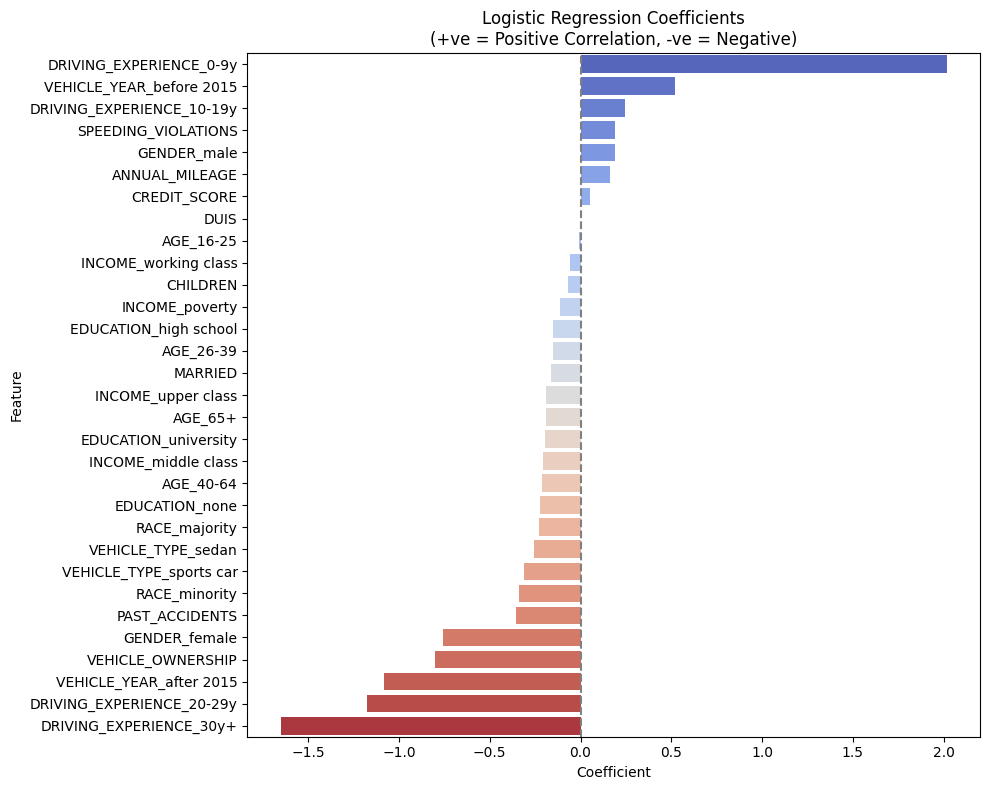

In [30]:
# Display logistic regression coefficients on bar plot
plt.figure(figsize=(10, 8))
sns.barplot(
    data=coefficient_df,
    x='Coefficient',
    y='Feature',
    palette='coolwarm',
    hue='Feature',
    dodge=False,
    legend=False
    )
plt.axvline(0, color='gray', linestyle='--')  # Reference line at 0
plt.title("Logistic Regression Coefficients\n(+ve = Positive Correlation, -ve = Negative)")
plt.tight_layout()
plt.savefig('../graphs/logistic_regression_coefficients.png')
plt.show()